# Training a Multi Layer Perceptron (MLP) with Gluon

# Lab objectives

1. End to end process of training a deep learning model
2. Data loading and data preparation with Gluon datasets, data loaders and data transformations
3. Building a neural network (deep learning model architecture) with Gluon Blocks
4. Concept of Loss function and optimizers
5. Training a deep learing model with Gluon
6. Saving the trained model

# Step 1 - Problem definition

* Given an image of the cloth, classify the clothing type as one of ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot'] classes

* This is an `Image Classification` problem

## Import required modules from MXNet

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Uncomment the following line if matplotlib is not installed.
# !pip install matplotlib

from mxnet import nd, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import datasets, transforms
from IPython import display
import matplotlib.pyplot as plt
import time

# Step 2 - Data collection and data preparation

1. Fashion MNIST - https://research.zalando.com/welcome/mission/research-projects/fashion-mnist/
2. Fashion MNIST has 60,000 gray scale images of size 28*28 for Training
3. Fashion MNIST has 10,000 gray scale images of size 28*28 for Testing
4. With Gluon `data.vision.datasets` module, you can easily use APIs to download and prepare standard datasets.

## Step 2.1 - Download the data

In [3]:
# Download the training data
fmnist_train = datasets.FashionMNIST(train=True)

# Download the validation(Test) data
fmnist_test = gluon.data.vision.FashionMNIST(train=False)

In [4]:
print("Number of training images - ", len(fmnist_train))
train_x, train_y = fmnist_train[0]
print("Each image is of shape - ", train_x.shape)

print("Number of test images - ", len(fmnist_test))
test_x, test_y = fmnist_test[0]
print("Each image is of shape - ", test_x.shape)

# NOTE1: shape = (28*28*1) and 1 here is because these are gray scale images i.e., channel=1
# NOTE2: A color image will have 3 channels for RGB. So, an equivalent color image would have been (28*28*3)

Number of training images -  60000
Each image is of shape -  (28, 28, 1)
Number of test images -  10000
Each image is of shape -  (28, 28, 1)


## Step 2.2 - Visualize sample data

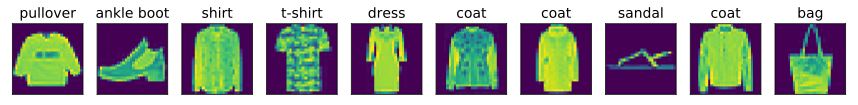

In [5]:
text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
               'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
X, y = fmnist_train[0:10]
# plot images
display.set_matplotlib_formats('svg')
_, figs = plt.subplots(1, X.shape[0], figsize=(15, 15))
for f,x,yi in zip(figs, X,y):
    # 3D->2D by removing the last channel dim
    f.imshow(x.reshape((28,28)).asnumpy())
    ax = f.axes
    ax.set_title(text_labels[int(yi)])
    ax.title.set_fontsize(14)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Step 2.3 - Data Preprocessing (Data Transformations)

1. Convert to `channels_first` format i.e., (28, 28, 1) => (1, 28, 28). MXNet runs faster with `channels_first` format
2. Convert all pixel values (0 to 255) to (0 to 1) with ToTensor transforms
3. Normalize the pixel value with mean 0.13 and standard deviation 0.31
4. `mxnet.gluon.data.vision.transforms` module provides many standard data transformation APIs
5. `mxnet.gluon.data.vision.transforms` has `Compose` that allows us to stack a list of transformations

In [6]:
# Chain all transforms together
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.13, 0.31)])

# Apply transformations on the training data
fmnist_train = fmnist_train.transform_first(transformer)

# Apply transformations on the test data
fmnist_test = fmnist_test.transform_first(transformer)

## Step 2.4 Data Loader

You know have a dataset for training data and test data. But, you need to feed this data into the neural network for training the model. You use data loader!

1. Data Loader reads the data from dataset and feed them as batches to the neural network for model training
2. Data Loader is fast, efficient and can run multiple processes in parallel to feed the batches of data for model training

Below, we prepare data loaders for training data and test data:
1. We use 4 workers to load the data in parallel
2. Randomly shuffle the training data (Intuition: Without shuffling, you will keep feeding the training data in same order leading to neural network memorizing rather than learn important feature)
3. Feed 256 images per batch during the model training

In [7]:
batch_size = 256

# Training data loader
train_data = gluon.data.DataLoader(
    fmnist_train, batch_size=batch_size, shuffle=True, num_workers=4)

# Test data loader
test_data = gluon.data.DataLoader(
    fmnist_test, batch_size=batch_size, shuffle=False, num_workers=4)

# Step 3 - Define the Neural Network 

## Gluon Basics

### I) Block

1. Takes an NDArray as input and gives out an NDArray as output
2. A Block can contain one or more other blocks
3. Each operation is a block, because, it takes an NDArray performs an operation and gives out an NDArray
4. Dense/FullyConnected, Convolution etc. are some examples of operation and available as block in MXNet Gluon

### II) Sequential

1. Helpful utility to stack a sequence of Blocks one on another
2. Under the hood, it just helps in pulling the output data from one block and push it as input to the next block and so on

## Multi Layer Perceptron

* A Multi Layer Perceptron graphically looks like below

![Multi Layer Perceptron](../assets/multilayer-perceptron.png)

In [8]:
net = nn.Sequential()

# Input (784, 1) Output (120, 1)
# NOTE: Units => Neuron => The circles you are seeing in above image
# NOTE: 784 => 28*28 i.e., we flatten our input image of shape (28, 28, 1) to (784, 1)
net.add(nn.Dense(units=120, activation="relu"))

# Input (120, 1) Output (84, 1)
net.add(nn.Dense(units=84, activation="relu"))

# Input (84, 1) Output (10, 1)
# NOTE: We have 10 classes of clothing, hence, in last layer, we output 10 values!
net.add(nn.Dense(units=10))

# NOTE: Do not worry about how we came with number 120 and 84. You can experiment with values!

In [9]:
# There should be some value for each of the neurons. Initialize all the blocks(layers) in the network
# We use Xavier initialization as a standard practice
net.initialize(init=init.Xavier())

## Loss Function, Optimizer and Trainer

* Loss Function - A way to measure the correctness
* Optimizer - A way to make changes so we decrease the Loss (error)
* Trainer - Updates the values(weights) in the network using Optimizer to reduce the Loss.

NOTE: Softmax cross entropy loss is used to measure error in multi class classification problem.
NOTE: Most widely used optimizer is Stochastic Gradient Descent (SGD)

In [10]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1})

# Step 4 - Train the model

In [11]:

def acc(output, label):
    """Helper function to calculate accuracy i.e., how 
    many predictions are correct.
    """
    # output: (batch, num_output) float32 ndarray
    # label: (batch, ) int32 ndarray
    return (output.argmax(axis=1) ==
            label.astype('float32')).mean().asscalar()

Training loop

1. Take a batch of training data from data loader
2. Do the forward pass (prediction)
3. Calculate the loss (error)
4. Do the backward pass (gradient - change required to reduce the loss)
5. Use Trainer with optimizer to make the updates (change in weights)
6. Continue with Step 1 with new batch of data

In [12]:
epochs = 5

for epoch in range(epochs):
    train_loss, train_acc, valid_acc = 0., 0., 0.
    tic = time.time()
    for data, label in train_data:
        # forward + backward
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        # update parameters
        trainer.step(batch_size)
        # calculate training metrics
        train_loss += loss.mean().asscalar()
        train_acc += acc(output, label)
    # calculate validation accuracy
    for data, label in test_data:
        valid_acc += acc(net(data), label)
    print("Epoch %d: loss %.3f, train acc %.3f, test acc %.3f, in %.1f sec" % (
            epoch, train_loss/len(train_data), train_acc/len(train_data),
            valid_acc/len(test_data), time.time()-tic))

Epoch 0: loss 0.629, train acc 0.773, test acc 0.843, in 5.5 sec
Epoch 1: loss 0.429, train acc 0.842, test acc 0.857, in 5.8 sec
Epoch 2: loss 0.384, train acc 0.859, test acc 0.870, in 5.6 sec
Epoch 3: loss 0.356, train acc 0.868, test acc 0.871, in 5.9 sec
Epoch 4: loss 0.336, train acc 0.876, test acc 0.871, in 6.1 sec


# Step 5 - Save the model
Finally, we save the trained parameters onto disk, so that we can use them later.

In [13]:
net.save_parameters('fashion_mnist.params')

# Summary

In this lab, we learnt about:

1. End to end process of training a deep learning model
2. Gluon Dataset, Data Loader and Transformers for data loading and preparation
3. Gluon Block - gluon.nn.Sequential, gluon.nn.Dense
4. Loss function - gluon.loss.SoftmaxCrossEntropyLoss
5. Trainer and optimizer - gluon.Train and SGD
6. Forward -> Loss -> Backward -> Update -> Repeat

# References
1. https://beta.mxnet.io/guide/crash-course/4-train.html
2. https://gluon.mxnet.io/chapter03_deep-neural-networks/mlp-scratch.html
3. https://gluon.mxnet.io/chapter03_deep-neural-networks/mlp-gluon.html
4. https://research.zalando.com/welcome/mission/research-projects/fashion-mnist/
5. https://mxnet.incubator.apache.org/tutorials/gluon/datasets.html